# Read Data

In [3]:
import pandas as pd
from pyathena.util import as_pandas
from datetime import datetime
import numpy as np
import functools as ft
import os
from typing import List, Set, Dict, Tuple
from utils import get_conn, ICDDataset, probs_to_preds, TREE, PROJ_DIR
from icd9.icd9 import ICD9, Node

In [106]:
notes = as_pandas(get_conn().cursor().execute("select text from mimiciii.noteevents limit 100"))["text"].tolist()

In [4]:
# read in raw data
subdir = "data"
roots_df = pd.read_csv(os.path.join(subdir, "roots.csv"), nrows=100000)
notes_df = pd.read_csv(os.path.join(subdir, "notes.csv"), nrows=100000)

In [5]:
# join icd roots with notes
df = roots_df.merge(notes_df, on="hadm_id", how="inner").dropna()

In [6]:
# group the data by admission id
model_df = df.groupby("hadm_id").aggregate(lambda x: list(set(x)))\
           .reset_index()\
           .loc[:, ["roots", "tokens"]]
model_df["tokens"] = model_df["tokens"].apply(lambda x: x[0])

# Exploratory Visualizations

In [12]:
from scripts.visdata import summary_table, note_lengths, icd_summary
import matplotlib.pyplot as plt
import seaborn as sns

## Summary Table

In [429]:
summary_table = pd.read_csv("data/full_summary.csv")

In [430]:
summary_table.columns = ["Category"] + list(summary_table.columns[1:])
summary_table = summary_table.set_index("Category")

In [435]:
summary_table.astype("int")

,Totals,Male,Medicare,Female,Private,Medicaid,Government,Self Pay
Category,,,,,,,,
Patients,46520,26121,21002,20399,19663,4570,1614,600
Admissions,58976,32950,28215,26026,22582,5785,1783,611
ICD9 Codes,11501,5852,5023,5649,5718,3989,2657,1467
Deaths,5836,3141,3903,2695,1372,381,90,95
Admissions Per Patient,1,1,1,1,1,1,1,1
ICD9 Codes Per Patient,0,0,0,0,0,0,1,2
ICD9 Codes Per Admission,0,0,0,0,0,0,1,2
Death Per Patient,0,0,0,0,0,0,0,0


In [432]:
icd_table = pd.read_csv("data/icd_summary.csv")

In [433]:
icd_table = icd_table.sort_values("Mimic-iii Counts", ascending=False)
icd_latex = icd_table.to_latex()

In [434]:
icd_table

,Code,Description,Mimic-iii Counts,Nodes in ICD Tree
2,390-459,DISEASES OF THE CIRCULATORY SYSTEM,124782,516
3,240-279,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES,...",52095,333
0,460-519,DISEASES OF THE RESPIRATORY SYSTEM,40989,277
11,800-999,INJURY AND POISONING,35518,1881
5,520-579,DISEASES OF THE DIGESTIVE SYSTEM,34595,625
1,580-629,DISEASES OF THE GENITOURINARY SYSTEM,32860,471
8,780-799,"SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS",28873,372
6,320-389,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,20397,1633
15,001-139,INFECTIOUS AND PARASITIC DISEASES,19507,1057
13,V10-V19,PERSONS WITH POTENTIAL HEALTH HAZARDS RELATED ...,18358,228


## Category Counts

In [36]:
ccounts_query = "select category, count(row_id) from mimiciii.noteevents group by category;"
ccounts_df = as_pandas(cursor.execute(ccounts_query))
ccounts_df.columns = ["category", "count"]
ccounts_df = ccounts_df.sort_values("count", ascending=False)

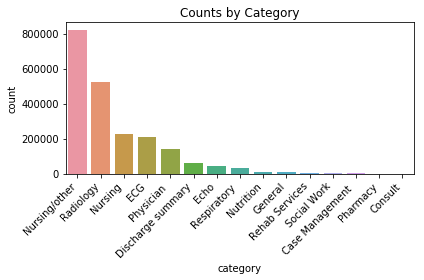

In [39]:
cat_fp = os.path.join(PROJ_DIR, "images", "categories.png")
ax = sns.barplot(x="category", y="count", data=ccounts_df)
ax.set_title("Counts by Category")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.savefig(cat_fp)
plt.show()

## Distribution of ICD Codes in Note

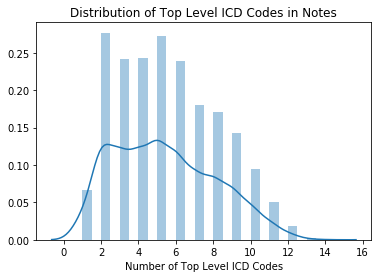

In [47]:
lens = [len(r) for r in model_df["roots"].tolist()]
ax = sns.distplot(lens)
ax.set(xlabel="Number of Top Level ICD Codes",
       title="Distribution of Top Level ICD Codes in Notes")
plt.savefig("images/num_icd_codes.png")
plt.show()

## Distribution of Word Counts in Notes

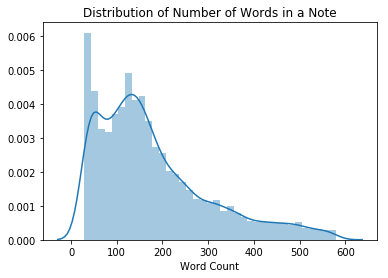

In [376]:
with get_conn() as conn:
    cursor = conn.cursor()
    notes = as_pandas(cursor.execute("select text from mimiciii.noteevents order by RAND() limit 10000;"))["text"]
lens = notes.apply(lambda x: len(x.split()))
no_outliers = lens[lens.between(lens.quantile(.1), lens.quantile(.9))]
ax = sns.distplot(no_outliers)
ax.set_title("Distribution of Number of Words in a Note")
ax.set_xlabel("Word Count")
plt.savefig("images/word_counts.png")
plt.show()

## ICD Codes by Insurance

In [413]:
# read data
with get_conn() as conn:
    cursor = conn.cursor()
    query = """
    select admissions.hadm_id as adm_id, count(diagnoses_icd.icd9_code) as icd, array_agg(admissions.insurance)[1] as insurance
    from mimiciii.admissions as admissions
    join mimiciii.diagnoses_icd as diagnoses_icd
    on admissions.hadm_id = diagnoses_icd.hadm_id
    group by admissions.hadm_id;
    """
    insur_icd_df = as_pandas(cursor.execute(query))

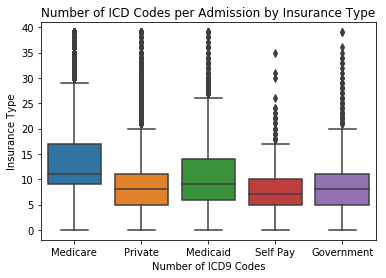

In [603]:
ax = sns.boxplot(x="insurance", y="icd", data=insur_icd_df)
ax.set(xlabel="Number of ICD9 Codes",
       ylabel="Insurance Type",
       title="Number of ICD Codes per Admission by Insurance Type")
plt.savefig("images/insurance.png")
plt.show()

## Word Cloud

In [111]:
from wordcloud import WordCloud

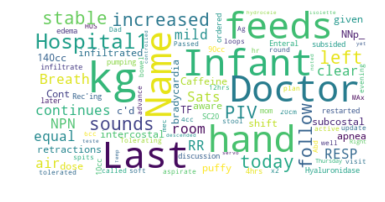

In [117]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(notes[15])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("images/wordcloud.png")
plt.show()

# Embedding

## Word2Vec

In [7]:
import gensim
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

In [8]:
# load word2vec embeddings
w2v_fp = os.path.join(PROJ_DIR, "data", "embeddings", "GoogleNews-vectors-negative300.bin")
word2vec = KeyedVectors.load_word2vec_format(w2v_fp, binary=True)

In [9]:
# embed with word2vec
model_df["w2v"] = model_df["tokens"].apply(lambda note: [word2vec[t] for t in note if t in word2vec])

In [10]:
emb_lens = [len(d) for d in model_df["w2v"].tolist()]

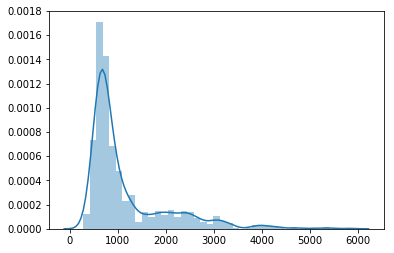

In [13]:
sns.distplot(emb_lens)
plt.show()

## BERT

In [651]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Models

## Prepare Data

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [16]:
# combine word embeddings
model_df["d2v"] = model_df["w2v"].apply(lambda x: np.mean(x, axis=0))

In [53]:
# one hot encode roots
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(model_df["roots"])
class_names = mlb.classes_

# extract combined word embeddings
X = np.array(model_df["d2v"].tolist())

# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

## Baseline Models

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [19]:
# instantiate classifiers
clfs = {
    "LogisticRegression": OneVsRestClassifier(LogisticRegression(multi_class="ovr")),
    "RandomForest": OneVsRestClassifier(RandomForestClassifier(n_estimators=150, criterion="entropy")),
    "MultiLayerPerceptron": MLPClassifier(hidden_layer_sizes=(40, 30))
}

In [20]:
# train baseline classifiers
trained_clfs = {name: clf.fit(X_train, Y_train) for name, clf in clfs.items()}

## LSTM

In [67]:
model_df.head()

,roots,tokens,w2v,d2v
0,"[760-779, 520-579, V01-V91]","['12:20', 'pm', 'babygram', 'chest', '&', 'abd...","[[0.05078125, -0.09326172, 0.064941406, 0.1142...","[-0.107172914, 0.073025964, 0.0694424, 0.14406..."
1,"[240-279, 680-709, 580-629, 001-139, 390-459, ...","['5:06', 'pm', 'ct', 'head', 'w/o', 'contrast'...","[[0.114746094, -0.05078125, 0.06738281, 0.0966...","[-0.1176455, 0.08826797, 0.058732, 0.14259975,..."
2,"[240-279, 580-629, 390-459, 320-389, 290-319, ...","['8:45', 'chest', '(', 'portable', 'ap', ')', ...","[[0.12792969, -0.055664062, 0.03466797, 0.0588...","[-0.12593232, 0.089721955, 0.051528513, 0.1402..."
3,"[780-799, 580-629, V01-V91, 390-459, 520-579, ...","['1:11', 'pm', 'chest', '(', 'portable', 'ap',...","[[0.05078125, -0.09326172, 0.064941406, 0.1142...","[-0.13639614, 0.100989304, 0.036371887, 0.1396..."
4,"[140-239, 390-459, 780-799]","['8:10', 'chest', '(', 'portable', 'ap', ')', ...","[[0.12792969, -0.055664062, 0.03466797, 0.0588...","[-0.13856685, 0.099781975, 0.032434996, 0.1406..."


In [68]:
# set X to be raw word embeddings
X = torch.FloatTensor(model_df["w2v"].tolist())

# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

ValueError: expected sequence of length 481 at dim 1 (got 762)

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [57]:
class LSTM(nn.Module):
    """An LSTM implementation."""

    def __init__(self, weights, embedding_dim, lstm_size, n_cat):
        super(LSTM, self).__init__()
        # define layers
        self.embeddings = nn.Embedding.from_pretrained(weights)
        self.lstm = nn.LSTM(embedding_dim, lstm_size, batch_first=True)
        self.hidden2tag = nn.Linear(lstm, n_cat)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2cat(lstm_out.view(len(sentence), -1))
        tag_scores = nn.Sigmoid()(cat_space, dim=1)
        return cat_scores
    
    def run_train(self, trainloader: DataLoader, n_epochs: int) -> None:
        """Train network on training set."""
        self.train()  # set model to train mode
        loss_fn = nn.BCELoss(reduction='mean')
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        # loop over the dataset for each epoch
        print("Training LSTM .....")
        for i in range(n_epochs):
            print(f"\tEpoch {i}:", end=" ")
            for data in trainloader:
                # extracts features/labels from loader
                feats, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # retrieve outputs
                breakpoint()
                outputs = self.forward(feats.unsqueeze(0))
                
                # determine loss and backprop
                loss = loss_fn(outputs, labels)
                loss.backward()  # calculate gradients
                optimizer.step()  # update parameters
                
            print(f"loss = {loss}")
        print("done.")

In [59]:
# declare train and test loaders
BATCH_SIZE = 64
trainset = ICDDataset(X_train, np.array(Y_train))
testset = ICDDataset(X_test, np.array(Y_test))
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, shuffle=False)

In [62]:
trainset.X.shape

(616,)

In [60]:
# train MLP
n_epochs = 30
n_feats = trainset.X.shape[1]
n_cats = len(top_level_roots)
lstm = LSTM(n_feats, 50, 35, n_cats)
lstm.run_train(trainloader, n_epochs)

IndexError: tuple index out of range

# Results

In [28]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, precision_recall_curve)
from utils import ml_accuracy

In [38]:
def ml_accuracy(Y_true: List[List[int]], Y_pred: List[List[int]]) -> float:
    """Calculate multi-label accuracy."""
    ratios = []
    for z, y in zip(Y_true, Y_pred):
        iz = [i for i, val in enumerate(z) if val]
        iy = [i for i, val in enumerate(y) if val]
        sz, sy = set(iz), set(iy)
        ratio = len(sz & sy) / len(sz | sy)
        ratios.append(ratio)
    acc = sum(ratios) / len(ratios)
    return acc

In [32]:
# store prediction and probability results
pred_clfs = {name: clf.predict(X_test) for name, clf in trained_clfs.items()}
prob_clfs = {name: clf.predict_proba(X_test) for name, clf in trained_clfs.items()}

## Performance Results

In [39]:
# get performance data
f1s = [f1_score(Y_test, preds, average="weighted", zero_division=1) for preds in pred_clfs.values()]
accs = [ml_accuracy(Y_test, preds) for preds in pred_clfs.values()]
precs = [precision_score(Y_test, preds, average="weighted", zero_division=1) for preds in pred_clfs.values()]
recs = [recall_score(Y_test, preds, average="weighted", zero_division=1) for preds in pred_clfs.values()]
metrics = f1s + accs + precs + recs
met_labels = ["F1 Score"] * len(pred_clfs) + ["Accuracy"] * len(pred_clfs)\
             + ["Precision"] * len(pred_clfs) + ["Recall"] * len(pred_clfs)
clf_names = list(pred_clfs.keys()) * 4

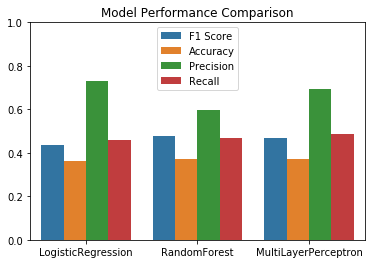

In [41]:
ax = sns.barplot(x=clf_names, y=metrics, hue=met_labels)
ax.set_ylim([0, 1])
ax.set(title="Model Performance Comparison")
plt.savefig("data/images/model_comparison.png")
plt.show()

## Classification Reports

In [42]:
class_reports = {name: classification_report(Y_test, Y_pred, target_names=class_names, 
                                             zero_division=1, output_dict=True)
                 for name, Y_pred in pred_clfs.items()}
crep_dfs = {name: pd.DataFrame(crep).T for name, crep in class_reports.items()}
crep_df = pd.concat(crep_dfs, axis=1)

In [43]:
crep_df

LogisticRegression                              \
                       f1-score precision    recall support   
001-139                0.335766  0.575000  0.237113    97.0   
140-239                0.000000  1.000000  0.000000    33.0   
240-279                0.716981  0.621495  0.847134   157.0   
290-319                0.000000  1.000000  0.000000    64.0   
320-389                0.000000  1.000000  0.000000    76.0   
390-459                0.879493  0.784906  1.000000   208.0   
460-519                0.441441  0.563218  0.362963   135.0   
520-579                0.000000  1.000000  0.000000   112.0   
580-629                0.519149  0.610000  0.451852   135.0   
680-709                0.000000  1.000000  0.000000    46.0   
710-739                0.000000  1.000000  0.000000    42.0   
760-779                0.000000  1.000000  0.000000    17.0   
780-799                0.388060  0.650000  0.276596    94.0   
800-999                0.292994  0.575000  0.196581   117.0   
V01-V91                0.752941  0.603774  1.000000   160.0   
micro avg              0.536950  0.649857  0.457468  1493.0   
macro avg              0.288455  0.798893  0.291483  1493.0   
weighted avg           0.434681  0.730056  0.457468  1493.0   
samples avg            0.497916  0.646572  0.456148  1493.0   

             MultiLayerPerceptron                             RandomForest  \
                         f1-score precision    recall support     f1-score   
001-139                  0.333333  0.560976  0.237113    97.0     0.384615   
140-239                  0.000000  1.000000  0.000000    33.0     0.000000   
240-279                  0.714667  0.614679  0.853503   157.0     0.670554   
290-319                  0.000000  1.000000  0.000000    64.0     0.028986   
320-389                  0.000000  1.000000  0.000000    76.0     0.180000   
390-459                  0.871795  0.784615  0.980769   208.0     0.872247   
460-519                  0.452174  0.547368  0.385185   135.0     0.584270   
520-579                  0.300654  0.560976  0.205357   112.0     0.284024   
580-629                  0.607407  0.607407  0.607407   135.0     0.536000   
680-709                  0.000000  1.000000  0.000000    46.0     0.000000   
710-739                  0.000000  1.000000  0.000000    42.0     0.044444   
760-779                  0.000000  1.000000  0.000000    17.0     0.666667   
780-799                  0.400000  0.658537  0.287234    94.0     0.343284   
800-999                  0.303797  0.585366  0.205128   117.0     0.343195   
V01-V91                  0.752941  0.603774  1.000000   160.0     0.666667   
micro avg                0.554373  0.641161  0.488279  1493.0     0.536098   
macro avg                0.315785  0.768246  0.317447  1493.0     0.373663   
weighted avg             0.466310  0.695135  0.488279  1493.0     0.478823   
samples avg              0.509544  0.640566  0.482755  1493.0     0.501522   

                                          
             precision    recall support  
001-139       0.508475  0.309278    97.0  
140-239       1.000000  0.000000    33.0  
240-279       0.618280  0.732484   157.0  
290-319       0.200000  0.015625    64.0  
320-389       0.375000  0.118421    76.0  
390-459       0.804878  0.951923   208.0  
460-519       0.590909  0.577778   135.0  
520-579       0.421053  0.214286   112.0  
580-629       0.582609  0.496296   135.0  
680-709       1.000000  0.000000    46.0  
710-739       0.333333  0.023810    42.0  
760-779       0.900000  0.529412    17.0  
780-799       0.575000  0.244681    94.0  
800-999       0.557692  0.247863   117.0  
V01-V91       0.626374  0.712500   160.0  
micro avg     0.628263  0.467515  1493.0  
macro avg     0.606240  0.344957  1493.0  
weighted avg  0.595117  0.467515  1493.0  
samples avg   0.639043  0.476330  1493.0

## Probability Distributions

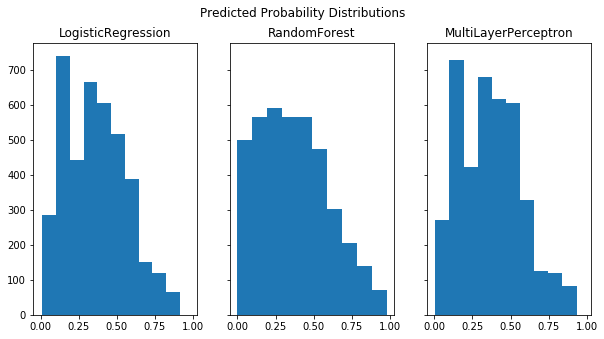

In [45]:
fig, axs = plt.subplots(1, len(prob_clfs), sharey="all", sharex="all")
for ax, name, probs in zip(axs, prob_clfs.keys(), prob_clfs.values()):
    ax.hist(probs.flatten())
    ax.set(title=name)
fig.set_size_inches(10, 5)
fig.suptitle("Predicted Probability Distributions")
plt.savefig("data/images/prob_dists.png")
plt.show()

## Precision/Recall Curves

In [46]:
def pr_curve(clf_name, probs, y_true, thresholds):
    """
    Generate precision/recall curve data for a given classifier.

    Implementation is custom because sklearn doesn't
    support multilabel classification for pr curve.
    """
    precs = []
    recs = []
    for thresh in thresholds:
        preds = probs_to_preds(probs, thresh)
        precs.append(precision_score(y_true, preds, average="weighted", zero_division=1))
        recs.append(recall_score(y_true, preds, average="weighted", zero_division=1))
    data = {"Classifier": [clf_name] * len(thresholds),
            "Precision": precs, 
            "Recall": recs, 
            "Threshold": thresholds}
    return pd.DataFrame(data)

In [47]:
# extract precision/recall data across thresholds
thresholds = np.linspace(0, 1, 100)
pr_dfs = [pr_curve(name, probs, Y_test, thresholds) for name, probs in prob_clfs.items()]
pr_df = pd.concat(pr_dfs)

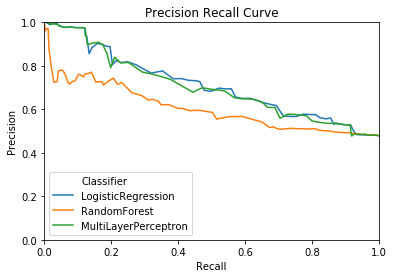

In [48]:
# plot precision recall curve for each classifier
ax = sns.lineplot(x="Recall", y="Precision", hue="Classifier", data=pr_df)
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set(title="Precision Recall Curve")
plt.savefig("data/images/prec_rec.png")
plt.show()

## Category Performance

In [366]:
# read in data
with get_conn() as conn:
    cursor = conn.cursor()
    query = f"""
    SELECT
      row_id as row_id,
      category
    FROM
      mimiciii.noteevents;
    """
    cat_df = as_pandas(cursor.execute(query))

In [377]:
cat_df.head()

,row_id,category
0,20030,Discharge summary
1,20031,Discharge summary
2,20032,Discharge summary
3,20033,Discharge summary
4,20034,Discharge summary


In [ ]:
merged_df = cat_df.merge(pd.DataFrame({"accaccs))